# Accelerated SGD

In [1]:
# Core Python Libraries
import pickle
import gzip
import math
import os
import time
import shutil
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import logging

# Disable warnings from logging
logging.disable(logging.WARNING)

# External Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import fastcore.all as fc
from fastcore.test import test_close

# Torch-related Libraries
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

# Torch configuration
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

# External Datasets
from datasets import load_dataset, load_dataset_builder

# miniai
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

# Set random seed for reproducibility
set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b):
    b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [3]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

#### SGD

In [4]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
    
    def reg_step(self, p):
        if self.wd != 0: 
            p *= 1 - self.lr * self.wd
    
    def opt_step(self, p):
        p -= p.grad * self.lr


    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [5]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.846,0.424,1,train
0.850,0.417,1,eval
0.865,0.372,2,train
0.848,0.409,2,eval


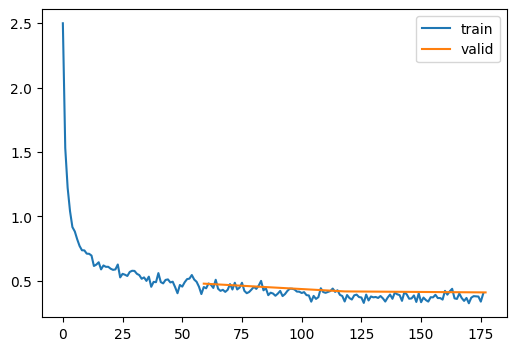

In [6]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr * wd * weight
```

...vs...

``` python
weight.grad += wd*weight
```

#### [Momentum](https://optimization.cbe.cornell.edu/index.php?title=Momentum#:~:text=Momentum%20is%20an%20extension%20to,concept%20of%20momentum%20in%20physics.)


In [7]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

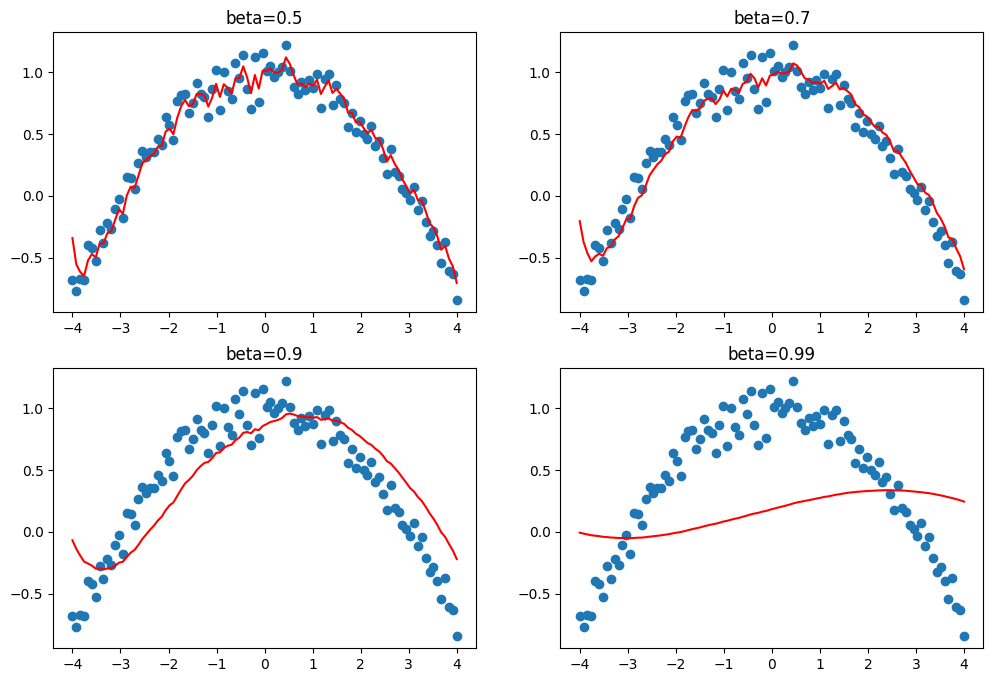

In [8]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [9]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1 - self.mom)
        p -= self.lr * p.grad_avg

In [10]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.786,0.597,0,train
0.846,0.416,0,eval
0.868,0.359,1,train
0.860,0.370,1,eval
0.885,0.314,2,train
0.869,0.359,2,eval


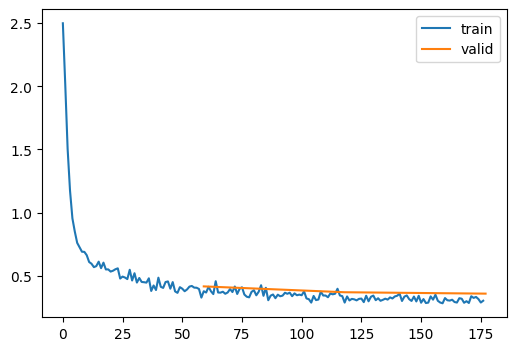

In [11]:
learn.fit(3)

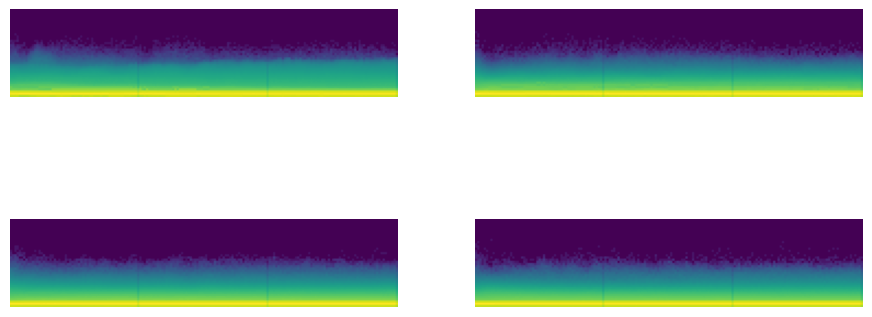

In [12]:
astats.color_dim()

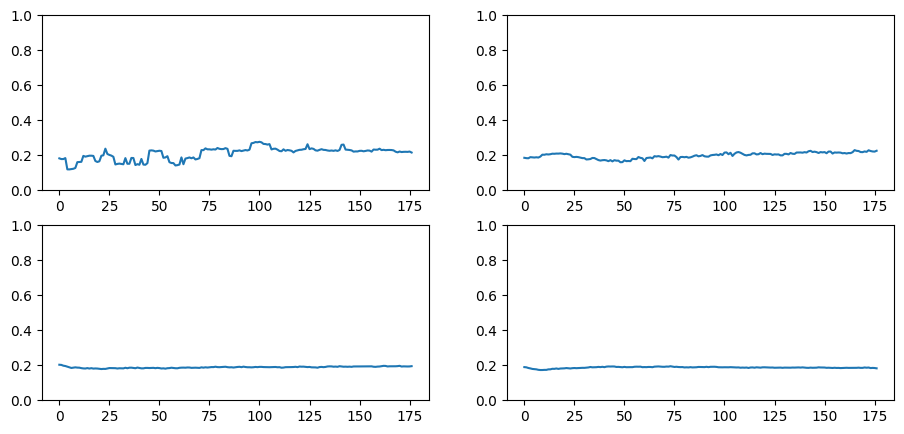

In [13]:
astats.dead_chart()

#### [RMSProp](https://optimization.cbe.cornell.edu/index.php?title=RMSProp#:~:text=RMSProp%2C%20root%20mean%20square%20propagation,lecture%20six%20by%20Geoff%20Hinton.)

In [14]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom, eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'):
            p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

#### Main Ideas of `RMSProp`

**Adaptive Learning Rate:**

The gradient is scaled down based on the square root of the moving average of squared gradients. This creates an adaptive learning rate, where large gradients are scaled down and small gradients are allowed to influence updates more:
$$ p \mathrel{-=} \frac{\text{lr} \times p.grad}{\sqrt{p.sqr\_avg} + \epsilon} $$

**Why Use `sqr_avg`?**

The averaging of squared gradients helps to stabilize the learning process. If a gradient is large, its squared value will dominate, slowing down the update for that parameter. If the gradient is small, the update proceeds with less dampening.

**The Role of `eps`:**
   - The epsilon term prevents division by zero, especially when the squared gradient values are very small. Without it, division by zero or extremely large updates could destabilize training.

#### Why would a dominating squared value slow down updates?

1. **Larger Gradients = Larger Squared Values:**
   - When the gradient for a particular parameter \( p \) is large, its squared value will be even larger. This causes \( p.sqr\_avg \) to increase.
   - **Example:**  
     If \( p.grad = 2 \), then \( p.grad^2 = 4 \). This value adds more weight to the moving average \( p.sqr\_avg \).

2. **Impact on Learning Rate:**
   - The update rule for RMSProp is:
     $$ 
     p \mathrel{-=} \frac{\text{lr} \times p.grad}{\sqrt{p.sqr\_avg} + \epsilon} 
     $$
   - As \( p.sqr\_avg \) grows larger, the denominator \( \sqrt{p.sqr\_avg} \) increases.
   - A larger denominator reduces the size of the update step because the gradient \( p.grad \) is divided by a bigger number.

3. **Slowing Down Updates:**
   - When \( p.sqr\_avg \) is large (due to large squared gradients), the effective learning rate for that parameter becomes smaller. This **slows down the updates** for that parameter.
   - **Intuition:** If a gradient is consistently large, RMSProp interprets it as a sign that updates should be more cautious, preventing overshooting during optimization.

#### Why is this good?
- **Adaptive Adjustment:** If a parameter experiences large fluctuations in its gradient, slowing down its update helps stabilize the training. Conversely, if a parameter has small gradients, RMSProp allows larger updates.
- **Preventing Exploding Gradients:** When gradients are large, updates can become too aggressive and lead to exploding gradients. RMSProp curbs this by reducing the effective learning rate for large gradients.

accuracy,loss,epoch,train
0.765,0.664,0,train
0.822,0.482,0,eval
0.848,0.416,1,train
0.845,0.426,1,eval
0.866,0.367,2,train
0.850,0.402,2,eval


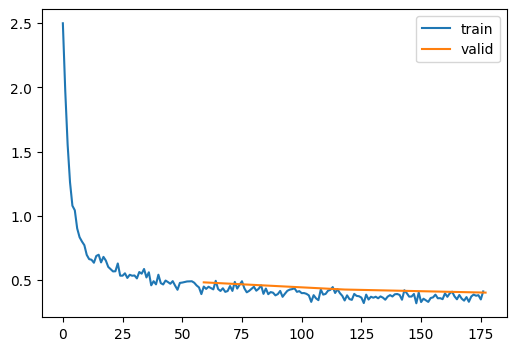

In [15]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

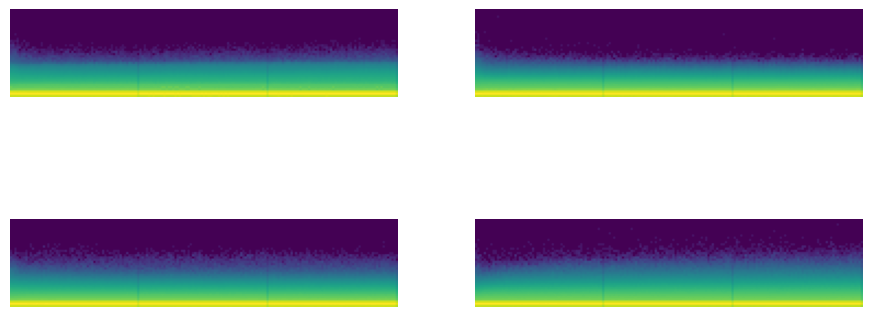

In [16]:
astats.color_dim()

#### [Adam](https://arxiv.org/abs/1412.6980v9)

In [17]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'):
            p.avg = torch.zeros_like(p.grad.data)

        if not hasattr(p, 'sqr_avg'):
            p.sqr_avg = torch.zeros_like(p.grad.data)

        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

Adam combines the ideas from both **Momentum** and **RMSProp** to provide a more robust and adaptive optimization algorithm. The key components are:

1. **Running Average of Gradients (Momentum-like Behavior):**
   $$ 
   p.avg = \beta_1 \cdot p.avg + (1 - \beta_1) \cdot p.grad
   $$
   - This computes an exponentially weighted moving average of the gradients, similar to Momentum, where `beta_1` controls the smoothness of this average.
   - \( p.avg \) accumulates the momentum of the gradient over time.

2. **Running Average of Squared Gradients (RMSProp-like Behavior):**
   $$ 
   p.sqr\_avg = \beta_2 \cdot p.sqr\_avg + (1 - \beta_2) \cdot (p.grad^2)
   $$
   - This tracks the moving average of squared gradients, where `beta_2` controls the smoothness of this moving average.
   - This part mimics the behavior of RMSProp by adapting the learning rate based on recent squared gradients.

3. **Bias-Correction:**
   - To counteract the bias introduced by initializing `p.avg` and `p.sqr_avg` to zeros, we apply bias correction:
     $$
     \text{unbias\_avg} = \frac{p.avg}{1 - \beta_1^{t+1}}
     $$
     $$
     \text{unbias\_sqr\_avg} = \frac{p.sqr\_avg}{1 - \beta_2^{t+1}}
     $$

   - This ensures that early iterations don't underestimate the gradient values.

4. **Update Step:**
   $$
   p \mathrel{-=} \frac{\text{lr} \cdot \text{unbias\_avg}}{\sqrt{\text{unbias\_sqr\_avg}} + \epsilon}
   $$

   - Adam combines the two running averages (of the gradient and squared gradient) to scale the update.
   - The bias-corrected running average of the gradient is divided by the square root of the bias-corrected squared gradient, ensuring that the update is adaptive and stable.

accuracy,loss,epoch,train
0.791,0.583,0,train
0.840,0.429,0,eval
0.870,0.360,1,train
0.858,0.381,1,eval
0.886,0.312,2,train
0.875,0.344,2,eval


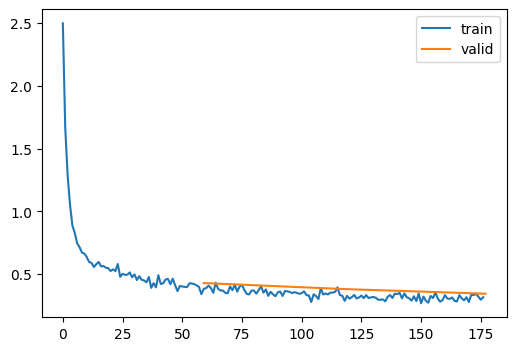

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [19]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [20]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [21]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [22]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [23]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [24]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [25]:
st

{'momentum_buffer': None}

In [26]:
len(opt.param_groups)

1

In [27]:
pg = opt.param_groups[0]

In [28]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [29]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

Cosine Annealing is a learning rate scheduler that reduces the learning rate following a cosine curve. This technique is designed to progressively lower the learning rate as training progresses, helping the model converge more effectively.

**Cosine Function for Learning Rate:**

   The learning rate is updated according to a cosine function over a predefined number of iterations or epochs:
   $$
   \text{lr}(t) = \frac{\text{lr}_{\text{min}}}{2} \left( 1 + \cos\left( \frac{t}{T} \pi \right) \right)
   $$
   where:
   - \( t \) is the current time step (iteration or epoch).
   - \( T \) is the total number of time steps (iterations or epochs).
   - \( \text{lr}_{\text{min}} \) is the minimum learning rate.

**Smooth Decay:**

The learning rate starts at its maximum value, then decays smoothly following the shape of the cosine function. This smooth decay helps the model avoid overshooting during training and leads to better convergence.

**Restarts (Optional):**

Sometimes, the cosine annealing schedule includes restarts, where the learning rate is periodically reset to a higher value (or even the maximum). This allows the model to escape local minima and explore other regions of the loss landscape before continuing the decay:

$$
T_{i+1} = \frac{T_i}{2}
$$

In [30]:
sched.base_lrs

[0.006]

In [31]:
sched.get_last_lr()

[0.006]

In [32]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

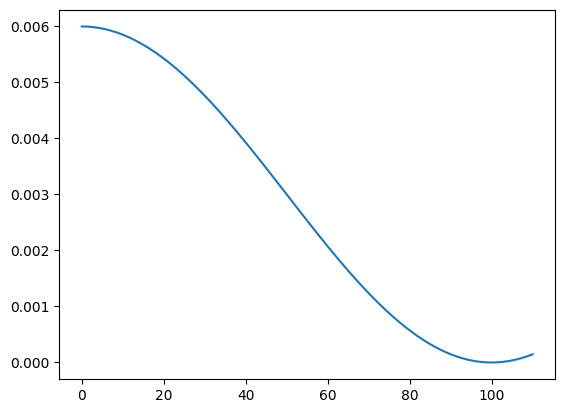

In [33]:
sched_lrs(sched, 110)

#### Scheduler Callbacks

In [34]:
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()


class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

In [35]:
def _lr(cb): return cb.pg['lr']

In [36]:
len(dls.train)

59

In [37]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.806,0.525,0,train
0.848,0.418,0,eval
0.878,0.331,1,train
0.880,0.329,1,eval
0.897,0.282,2,train
0.881,0.317,2,eval


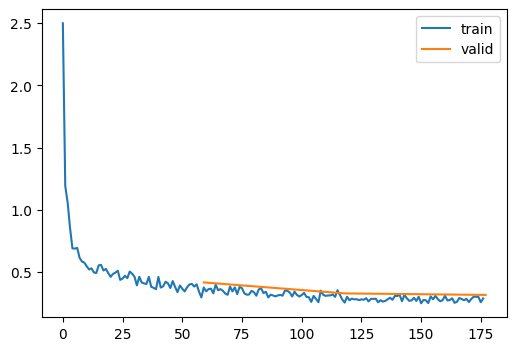

In [38]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

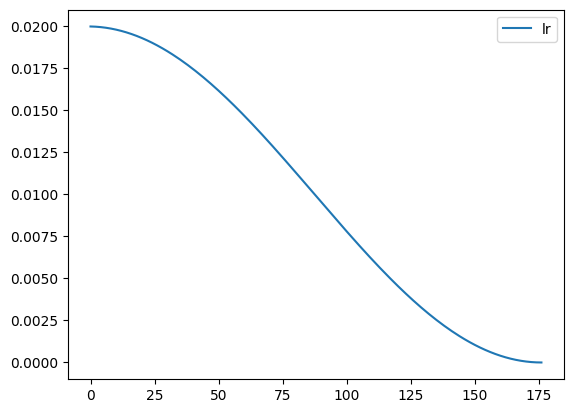

In [39]:
rec.plot()

accuracy,loss,epoch,train
0.807,0.524,0,train
0.857,0.381,0,eval
0.879,0.328,1,train
0.872,0.336,1,eval
0.899,0.274,2,train
0.883,0.309,2,eval


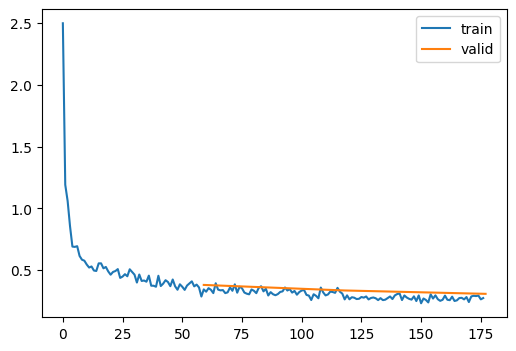

In [40]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

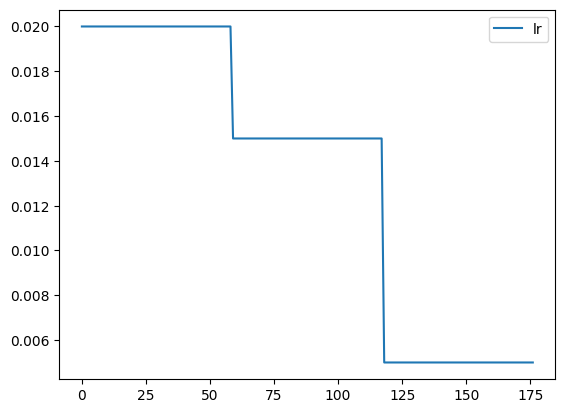

In [41]:
rec.plot()

## 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

1Cycle is a training strategy that adjusts the learning rate and momentum dynamically throughout the training process.

### Key Concepts:

1. **Learning Rate Schedule:**
   The learning rate is increased in the first half of the training and then decreased in the second half, following a triangular shape:
   $$
   \text{lr}(t) =
   \begin{cases}
   \text{lr}_{\text{max}} - (\text{lr}_{\text{max}} - \text{lr}_{\text{min}}) \cdot \frac{t}{T/2} & \text{if } t \leq T/2 \\
   \text{lr}_{\text{min}} + (\text{lr}_{\text{max}} - \text{lr}_{\text{min}}) \cdot \frac{t - T/2}{T/2} & \text{if } t > T/2
   \end{cases}
   $$
   - \( \text{lr}_{\text{max}} \): Maximum learning rate (reached halfway through training).
   - \( \text{lr}_{\text{min}} \): Minimum learning rate (start and end of the cycle).
   - \( t \): Current time step.
   - \( T \): Total training time.

2. **Momentum Schedule:**
   Momentum follows an inverse pattern of the learning rate. When the learning rate is high, momentum is low, and vice versa:
   $$
   \text{mom}(t) =
   \begin{cases}
   \text{mom}_{\text{min}} + (\text{mom}_{\text{max}} - \text{mom}_{\text{min}}) \cdot \frac{t}{T/2} & \text{if } t \leq T/2 \\
   \text{mom}_{\text{max}} - (\text{mom}_{\text{max}} - \text{mom}_{\text{min}}) \cdot \frac{t - T/2}{T/2} & \text{if } t > T/2
   \end{cases}
   $$
   - \( \text{mom}_{\text{max}} \): Maximum momentum.
   - \( \text{mom}_{\text{min}} \): Minimum momentum.

3. **Super-convergence:**
   The key insight behind 1Cycle is the concept of super-convergence. By increasing the learning rate aggressively and then decreasing it, the model is pushed to learn faster and converge more effectively. The initial increase helps the model escape poor local minima, and the decrease ensures fine-tuning at the end of training.

In [42]:
def _beta1(cb):
    return cb.pg['betas'][0]

rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.767,0.659,0,train
0.845,0.454,0,eval
0.857,0.390,1,train
0.858,0.399,1,eval
0.884,0.311,2,train
0.881,0.331,2,eval
0.906,0.253,3,train
0.893,0.290,3,eval
0.921,0.215,4,train
0.901,0.271,4,eval


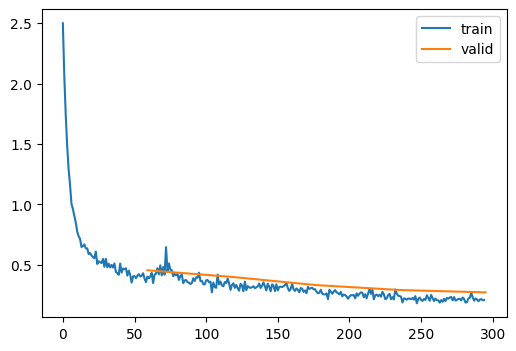

In [43]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)